In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Loading the data

In [2]:
deaths = pd.read_csv('./DATASETS/COVID-Time Series Data - Refined/deaths.csv')

deaths = deaths.melt(['State', 'Country'], deaths.columns[4:], var_name='Dates', value_name='Deaths')
deaths.Dates = pd.to_datetime(deaths.Dates)

deaths.head()

,State,Country,Dates,Deaths
0,Alabama,US,2020-01-22,0
1,Alabama,US,2020-01-22,0
2,Alabama,US,2020-01-22,0
3,Alabama,US,2020-01-22,0
4,Alabama,US,2020-01-22,0


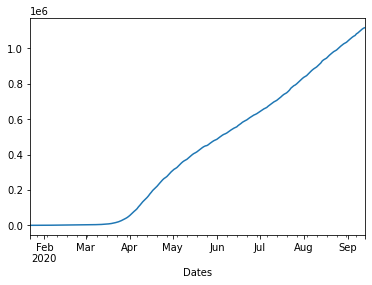

In [3]:
days = deaths.groupby('Dates').sum()
days.Deaths.resample('d').sum().plot();

In [4]:
days.head()

,Deaths
Dates,
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56


In [5]:
days.tail()

,Deaths
Dates,
2020-09-09,1094545
2020-09-10,1101245
2020-09-11,1108335
2020-09-12,1113924
2020-09-13,1116808


In [6]:
len(days)

236

# 2. Preparing the data for the LSTM model

In [7]:
# number of data in the test set
test_size = 30
test_ind = len(days) - test_size

train = days.iloc[:test_ind,:]
test = days.iloc[test_ind:,:]

In [8]:
from sklearn.preprocessing import MinMaxScaler

# The data is scaled
scaler = MinMaxScaler(feature_range=(0,10))

scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# batch size should be less than len(test)
BS = 15

generator = TimeseriesGenerator(scaled_train, scaled_train, length=BS, batch_size=1)

In [10]:
x1, y1 = generator[0]
x2, y2 = generator[1]

In [11]:
# given data of last BS days it will predict the expected number of cases for the (BS+1)th day

print(f'example 1: {x1}\n{y1}\n\n\nexample 2: {x2}\n{y2}')

example 1: [[[0.00000000e+00]
  [1.07669051e-05]
  [9.69021461e-05]
  [2.69172628e-04]
  [4.19909300e-04]
  [6.99848833e-04]
  [1.22742718e-03]
  [1.24896099e-03]
  [1.65810339e-03]
  [2.11031340e-03]
  [2.60559104e-03]
  [3.71458227e-03]
  [4.40366419e-03]
  [5.11427993e-03]
  [5.88949710e-03]]]
[[0.00664318]]


example 2: [[[1.07669051e-05]
  [9.69021461e-05]
  [2.69172628e-04]
  [4.19909300e-04]
  [6.99848833e-04]
  [1.22742718e-03]
  [1.24896099e-03]
  [1.65810339e-03]
  [2.11031340e-03]
  [2.60559104e-03]
  [3.71458227e-03]
  [4.40366419e-03]
  [5.11427993e-03]
  [5.88949710e-03]
  [6.64318046e-03]]]
[[0.00755837]]


In [12]:
valGenerator = TimeseriesGenerator(scaled_test, scaled_test, length=BS, batch_size=1)

# 3. Building and compiling the model

In [13]:
# part 1: Building the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.regularizers import l1

n_features = 1
model = Sequential()

# a. input layer
model.add(LSTM(58, activation=None, input_shape=(BS, n_features)))

# b. hidden layers
# model.add(Dense(18, activation='relu', kernel_regularizer=l1()))

# c. final layer
model.add(Dense(1))


# part 2: compiling the model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(), loss='mse')

print(model.summary())

# part 3: training the model
EPOCHS = 18

# Without early stopping

# """

H = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator)

# """

# With early stopping
"""

from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor='val_loss', patience=4)
H = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator, callbacks=[earlyStop])


"""

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 58)                13920     
_________________________________________________________________
dense (Dense)                (None, 1)                 59        
Total params: 13,979
Trainable params: 13,979
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/18
191/191 [==============================] - 6s 30ms/step - loss: 0.9833 - val_loss: 0.1130
Epoch 2/18
191/191 [==============================] - 5s 28ms/step - loss: 0.0209 - val_loss: 9.7572e-04
Epoch 3/18
191/191 [==============================] - 5s 28ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 4/18
191/191 [==============================] - 6s 30ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 5/18
191/191 [==============================] - 6s 29ms/step - loss: 0.0035 - val_loss: 0.0485


"\n\nfrom tensorflow.keras.callbacks import EarlyStopping\nearlyStop = EarlyStopping(monitor='val_loss', patience=4)\nH = model.fit_generator(generator, epochs=EPOCHS, validation_data=valGenerator, callbacks=[earlyStop])\n\n\n"

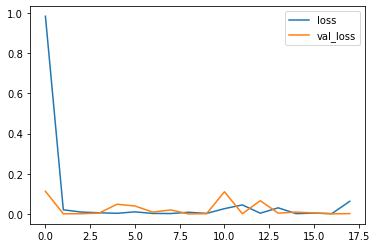

In [14]:
losses = pd.DataFrame(H.history)
losses.plot();

# 4. Evaluating the model

In [15]:
# last 12 rows from scaled_train
first_eval_batch = scaled_train[-BS:]
print(first_eval_batch)

[[ 8.92931742]
 [ 9.00035746]
 [ 9.05089731]
 [ 9.10306297]
 [ 9.19270822]
 [ 9.28237501]
 [ 9.36568932]
 [ 9.44691485]
 [ 9.51675976]
 [ 9.5711434 ]
 [ 9.62994147]
 [ 9.71049946]
 [ 9.79785136]
 [ 9.87648206]
 [10.        ]]


In [16]:
# array to store the forcasted results
test_predictions = []

current_batch = first_eval_batch.reshape((1, BS, n_features))

count=1

for i in range(len(test)):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred) 
    
    print(f'Result {count}:')
    print(f'current batch:\n{current_batch},\n prediction: {current_pred}')
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    count += 1

    print('\n\n')

Result 1:
current batch:
[[[ 8.92931742]
  [ 9.00035746]
  [ 9.05089731]
  [ 9.10306297]
  [ 9.19270822]
  [ 9.28237501]
  [ 9.36568932]
  [ 9.44691485]
  [ 9.51675976]
  [ 9.5711434 ]
  [ 9.62994147]
  [ 9.71049946]
  [ 9.79785136]
  [ 9.87648206]
  [10.        ]]],
 prediction: [9.929077]



Result 2:
current batch:
[[[ 9.00035746]
  [ 9.05089731]
  [ 9.10306297]
  [ 9.19270822]
  [ 9.28237501]
  [ 9.36568932]
  [ 9.44691485]
  [ 9.51675976]
  [ 9.5711434 ]
  [ 9.62994147]
  [ 9.71049946]
  [ 9.79785136]
  [ 9.87648206]
  [10.        ]
  [ 9.92907715]]],
 prediction: [9.963968]



Result 3:
current batch:
[[[ 9.05089731]
  [ 9.10306297]
  [ 9.19270822]
  [ 9.28237501]
  [ 9.36568932]
  [ 9.44691485]
  [ 9.51675976]
  [ 9.5711434 ]
  [ 9.62994147]
  [ 9.71049946]
  [ 9.79785136]
  [ 9.87648206]
  [10.        ]
  [ 9.92907715]
  [ 9.96396828]]],
 prediction: [10.011584]



Result 4:
current batch:
[[[ 9.10306297]
  [ 9.19270822]
  [ 9.28237501]
  [ 9.36568932]
  [ 9.44691485]
  [ 9.516

In [17]:
true_predictions = scaler.inverse_transform(test_predictions)
print(true_predictions)

[[ 922201.88413086]
 [ 925442.4744545 ]
 [ 929864.91566887]
 [ 935109.86062088]
 [ 940557.9071312 ]
 [ 946117.64621239]
 [ 951751.96510696]
 [ 957460.42094193]
 [ 963229.37322884]
 [ 969071.48813553]
 [ 975022.28407669]
 [ 981084.94973793]
 [ 987210.94623833]
 [ 993360.68073158]
 [ 999526.27007828]
 [1005565.64061966]
 [1011891.99286575]
 [1018395.84861069]
 [1025053.5584362 ]
 [1031838.63853683]
 [1038745.15441437]
 [1045772.2203228 ]
 [1052921.16488113]
 [1060193.22813377]
 [1067591.24446793]
 [1075116.80822639]
 [1082771.95662498]
 [1090557.7525589 ]
 [1098475.61322174]
 [1106529.25874672]]


In [18]:
test['Predictions'] = true_predictions.astype(int)
test

C:\Users\Python\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Deaths,Predictions
Dates,,
2020-08-15,935172,922201
2020-08-16,939931,925442
2020-08-17,944510,929864
2020-08-18,952708,935109
2020-08-19,960811,940557
2020-08-20,967915,946117
2020-08-21,974560,951751
2020-08-22,981105,957460
2020-08-23,985416,963229


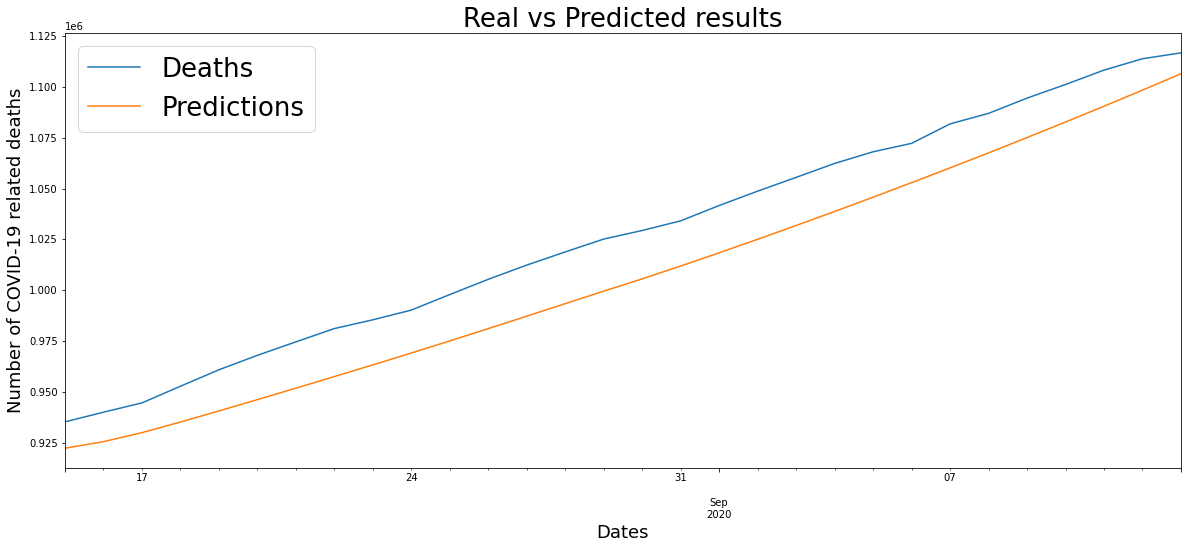

In [19]:
test.plot(figsize=(20,8));
plt.title('Real vs Predicted results', fontsize=26)
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Number of COVID-19 related deaths', fontsize=18)
plt.legend(loc=2, prop={'size': 26})

In [20]:
from sklearn.metrics import r2_score, mean_squared_error

mse = mean_squared_error(test.Deaths, test.Predictions)
length = len(test)
rmse = np.sqrt(mse/length)

r2s = r2_score(test.Deaths, test.Predictions) 

print(f'RMSE = {rmse}; r2 score = {r2s}')

RMSE = 3835.58779792036; r2 score = 0.854863094575889


# 5. Forecasting the number of confirmed cases for the next N days

In [21]:
from pandas.tseries.offsets import DateOffset

ndays=60
last_date = days.index[-1]
future_dates = [last_date+DateOffset(days=x) for x in range(1, ndays+1)]

In [22]:
days_copy = days.copy()
days_copy.tail()

,Deaths
Dates,
2020-09-09,1094545
2020-09-10,1101245
2020-09-11,1108335
2020-09-12,1113924
2020-09-13,1116808


In [23]:
# get the scaled data for the last BS days in our dataset
last_index = len(days)
last_n_days = scaler.transform(days_copy.iloc[-BS:last_index,:])
last_n_days

array([[11.08302145],
       [11.13421809],
       [11.21547592],
       [11.29158717],
       [11.36453295],
       [11.43851236],
       [11.50010982],
       [11.54495398],
       [11.64803633],
       [11.70383043],
       [11.78467912],
       [11.85681739],
       [11.93315475],
       [11.99333098],
       [12.02438273]])

In [24]:
# array to store the forcasted results for the next ndays
test_predictions_ndays = []

current_batch = last_n_days.reshape((1, BS, n_features))

count=1

for i in range(ndays):
    
    current_pred = model.predict(current_batch)[0]
    test_predictions_ndays.append(current_pred) 
    
    print(f'Result {count}:')
    print(f'current batch:\n{current_batch},\n prediction: {current_pred}')
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    count += 1

    print('\n\n')

Result 1:
current batch:
[[[11.08302145]
  [11.13421809]
  [11.21547592]
  [11.29158717]
  [11.36453295]
  [11.43851236]
  [11.50010982]
  [11.54495398]
  [11.64803633]
  [11.70383043]
  [11.78467912]
  [11.85681739]
  [11.93315475]
  [11.99333098]
  [12.02438273]]],
 prediction: [12.184215]



Result 2:
current batch:
[[[11.13421809]
  [11.21547592]
  [11.29158717]
  [11.36453295]
  [11.43851236]
  [11.50010982]
  [11.54495398]
  [11.64803633]
  [11.70383043]
  [11.78467912]
  [11.85681739]
  [11.93315475]
  [11.99333098]
  [12.02438273]
  [12.18421459]]],
 prediction: [12.2926445]



Result 3:
current batch:
[[[11.21547592]
  [11.29158717]
  [11.36453295]
  [11.43851236]
  [11.50010982]
  [11.54495398]
  [11.64803633]
  [11.70383043]
  [11.78467912]
  [11.85681739]
  [11.93315475]
  [11.99333098]
  [12.02438273]
  [12.18421459]
  [12.2926445 ]]],
 prediction: [12.394779]



Result 4:
current batch:
[[[11.29158717]
  [11.36453295]
  [11.43851236]
  [11.50010982]
  [11.54495398]
  [11.

Result 30:
current batch:
[[[13.6674118 ]
  [13.7882576 ]
  [13.91044903]
  [14.03428841]
  [14.15987492]
  [14.28743744]
  [14.41705513]
  [14.54876804]
  [14.68258095]
  [14.8184967 ]
  [14.95649338]
  [15.09655857]
  [15.23866463]
  [15.38277912]
  [15.52885628]]],
 prediction: [15.676844]



Result 31:
current batch:
[[[13.7882576 ]
  [13.91044903]
  [14.03428841]
  [14.15987492]
  [14.28743744]
  [14.41705513]
  [14.54876804]
  [14.68258095]
  [14.8184967 ]
  [14.95649338]
  [15.09655857]
  [15.23866463]
  [15.38277912]
  [15.52885628]
  [15.67684364]]],
 prediction: [15.826661]



Result 32:
current batch:
[[[13.91044903]
  [14.03428841]
  [14.15987492]
  [14.28743744]
  [14.41705513]
  [14.54876804]
  [14.68258095]
  [14.8184967 ]
  [14.95649338]
  [15.09655857]
  [15.23866463]
  [15.38277912]
  [15.52885628]
  [15.67684364]
  [15.82666111]]],
 prediction: [15.978193]



Result 33:
current batch:
[[[14.03428841]
  [14.15987492]
  [14.28743744]
  [14.41705513]
  [14.54876804]
  [

In [25]:
true_predictions_ndays = scaler.inverse_transform(test_predictions_ndays).astype(int)
future_dates_df = pd.DataFrame(index=future_dates[:],columns=days.columns, data=true_predictions_ndays)
future_df = pd.concat([days_copy,future_dates_df])

In [26]:
future_df.head()

,Deaths
2020-01-22,17
2020-01-23,18
2020-01-24,26
2020-01-25,42
2020-01-26,56


In [27]:
future_df.tail()

,Deaths
2020-11-08,1823225
2020-11-09,1834571
2020-11-10,1845451
2020-11-11,1855846
2020-11-12,1865741


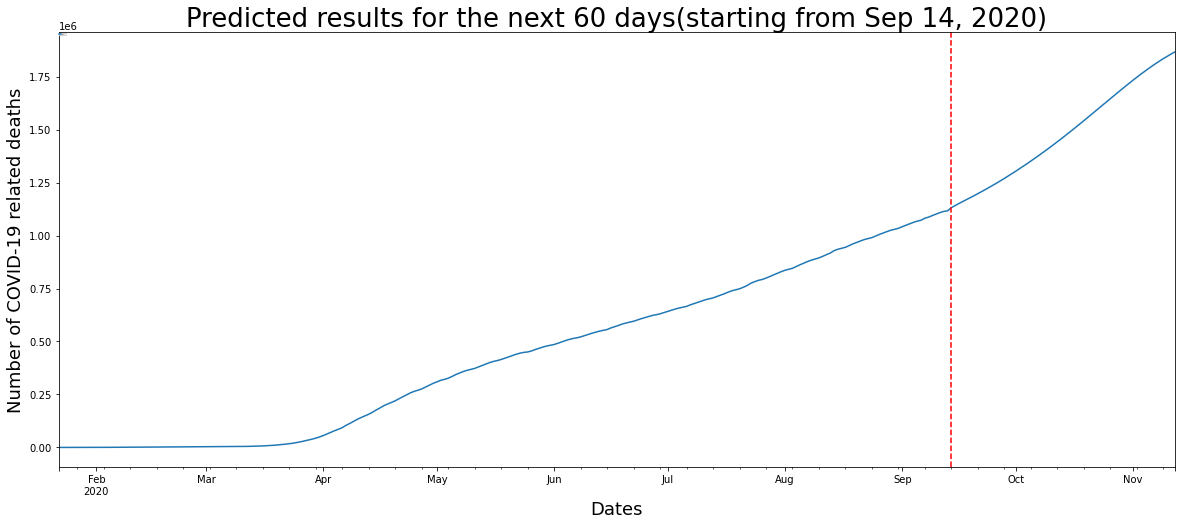

In [28]:
future_df.plot(figsize=(20,8));

plt.axvline("2020-09-14", color="red", linestyle="--");

plt.title(f'Predicted results for the next {ndays} days(starting from Sep 14, 2020)', fontsize=26);
plt.xlabel('Dates', fontsize=18);
plt.ylabel('Number of COVID-19 related deaths', fontsize=18);
plt.legend(loc=2, prop={'size': 0});